In [26]:
#this notebook establishes baseline auc for CheXpert -to cheXphoto transfer rate
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torchvision
import torch
import os
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader
import pickle

In [3]:
acorn = 1234
torch.manual_seed(acorn)
np.random.seed(acorn)

torch.cuda.is_available()

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  

In [38]:
train = datasets.CIFAR100(
    root="data",
    train=True,
)

In [66]:
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
#    target_transform=Lambda(lambda y: torch.zeros(100, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
#    target_transform=Lambda(lambda y: torch.zeros(100, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

Files already downloaded and verified
Files already downloaded and verified


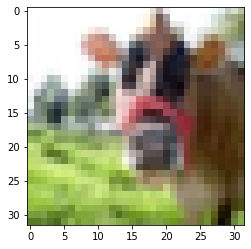

In [40]:
plt.imshow(train.__getitem__(0)[0])

In [67]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)



In [49]:
with open("data/cifar-100-python/meta", 'rb') as fo:
    labels = pickle.load(fo)



In [50]:
labels

{'fine_label_names': ['apple',
  'aquarium_fish',
  'baby',
  'bear',
  'beaver',
  'bed',
  'bee',
  'beetle',
  'bicycle',
  'bottle',
  'bowl',
  'boy',
  'bridge',
  'bus',
  'butterfly',
  'camel',
  'can',
  'castle',
  'caterpillar',
  'cattle',
  'chair',
  'chimpanzee',
  'clock',
  'cloud',
  'cockroach',
  'couch',
  'crab',
  'crocodile',
  'cup',
  'dinosaur',
  'dolphin',
  'elephant',
  'flatfish',
  'forest',
  'fox',
  'girl',
  'hamster',
  'house',
  'kangaroo',
  'keyboard',
  'lamp',
  'lawn_mower',
  'leopard',
  'lion',
  'lizard',
  'lobster',
  'man',
  'maple_tree',
  'motorcycle',
  'mountain',
  'mouse',
  'mushroom',
  'oak_tree',
  'orange',
  'orchid',
  'otter',
  'palm_tree',
  'pear',
  'pickup_truck',
  'pine_tree',
  'plain',
  'plate',
  'poppy',
  'porcupine',
  'possum',
  'rabbit',
  'raccoon',
  'ray',
  'road',
  'rocket',
  'rose',
  'sea',
  'seal',
  'shark',
  'shrew',
  'skunk',
  'skyscraper',
  'snail',
  'snake',
  'spider',
  'squirrel

In [44]:
len(train_dataloader)

782

In [133]:
class Resnext50(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        resnet = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        resnet.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
#         self.soft = torch.nn.Softmax()

    def forward(self, x):

        return self.base_model(x)

# Initialize the model
learning_rate = 1e-4
batch_size = 64
epochs = 10
model = Resnext50(100)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# checkpt = torch.load('CheXpert_0_resnet50')
# chexpert_model.load_state_dict(checkpt['model_state_dict'])
# optimizer.load_state_dict(checkpt['optimizer_state_dict'])

model.to(device)
loss_fn = torch.nn.CrossEntropyLoss().to(device)


In [164]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] acc: {(100*correct/64):>0.1f}%")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [116]:
# resnext lr=1e-4 epochs=20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.834321  [    0/50000]
loss: 3.762840  [ 6400/50000]
loss: 3.170149  [12800/50000]
loss: 2.648679  [19200/50000]
loss: 2.153364  [25600/50000]
loss: 2.086865  [32000/50000]
loss: 2.736150  [38400/50000]
loss: 2.166894  [44800/50000]
Test Error: 
 Accuracy: 47.2%, Avg loss: 0.030783 

Epoch 2
-------------------------------
loss: 1.260587  [    0/50000]
loss: 1.771301  [ 6400/50000]
loss: 1.614566  [12800/50000]
loss: 1.303818  [19200/50000]
loss: 2.156773  [25600/50000]
loss: 1.702928  [32000/50000]
loss: 1.625726  [38400/50000]
loss: 1.567609  [44800/50000]
Test Error: 
 Accuracy: 54.0%, Avg loss: 0.026828 

Epoch 3
-------------------------------
loss: 0.995247  [    0/50000]
loss: 1.124683  [ 6400/50000]
loss: 1.508117  [12800/50000]
loss: 1.199805  [19200/50000]
loss: 1.141508  [25600/50000]
loss: 1.378473  [32000/50000]
loss: 1.188814  [38400/50000]
loss: 1.098660  [44800/50000]
Test Error: 
 Accuracy: 55.7%, Avg loss: 0.026225 

Epoc

KeyboardInterrupt: 

In [99]:
# lr 1e-3

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.693388  [    0/50000]
loss: 3.782035  [ 6400/50000]
loss: 3.437772  [12800/50000]
loss: 3.404156  [19200/50000]
loss: 3.073623  [25600/50000]
loss: 3.112524  [32000/50000]
loss: 2.557342  [38400/50000]
loss: 2.224792  [44800/50000]
Test Error: 
 Accuracy: 36.2%, Avg loss: 0.039299 

Epoch 2
-------------------------------
loss: 2.505208  [    0/50000]
loss: 2.259551  [ 6400/50000]
loss: 2.560164  [12800/50000]
loss: 1.987200  [19200/50000]
loss: 2.619271  [25600/50000]
loss: 2.892432  [32000/50000]
loss: 2.317332  [38400/50000]
loss: 2.237772  [44800/50000]
Test Error: 
 Accuracy: 40.1%, Avg loss: 0.036478 

Epoch 3
-------------------------------
loss: 1.989111  [    0/50000]
loss: 2.036504  [ 6400/50000]
loss: 2.505474  [12800/50000]
loss: 1.934663  [19200/50000]
loss: 2.304322  [25600/50000]
loss: 2.233503  [32000/50000]
loss: 1.998961  [38400/50000]
loss: 1.859582  [44800/50000]
Test Error: 
 Accuracy: 44.9%, Avg loss: 0.032707 

Epoc

In [105]:
#learning rate 1e-4

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.725864  [    0/50000]
loss: 3.968250  [ 6400/50000]
loss: 3.236192  [12800/50000]
loss: 2.500150  [19200/50000]
loss: 2.470026  [25600/50000]
loss: 2.090750  [32000/50000]
loss: 2.027941  [38400/50000]
loss: 2.247874  [44800/50000]
Test Error: 
 Accuracy: 47.2%, Avg loss: 0.030655 

Epoch 2
-------------------------------
loss: 1.401441  [    0/50000]
loss: 1.576713  [ 6400/50000]
loss: 1.269603  [12800/50000]
loss: 1.776221  [19200/50000]
loss: 1.313246  [25600/50000]
loss: 1.702384  [32000/50000]
loss: 1.785173  [38400/50000]
loss: 1.838932  [44800/50000]
Test Error: 
 Accuracy: 53.5%, Avg loss: 0.027126 

Epoch 3
-------------------------------
loss: 1.111194  [    0/50000]
loss: 1.058957  [ 6400/50000]
loss: 0.935262  [12800/50000]
loss: 1.211025  [19200/50000]
loss: 1.189626  [25600/50000]
loss: 1.122601  [32000/50000]
loss: 1.070213  [38400/50000]
loss: 1.125145  [44800/50000]
Test Error: 
 Accuracy: 55.7%, Avg loss: 0.026264 

Epoc

In [109]:
#learnig rate 1e-5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.762182  [    0/50000]
loss: 4.616714  [ 6400/50000]
loss: 4.678048  [12800/50000]
loss: 4.498742  [19200/50000]
loss: 4.314584  [25600/50000]
loss: 4.222754  [32000/50000]
loss: 4.113218  [38400/50000]
loss: 3.986754  [44800/50000]
Test Error: 
 Accuracy: 16.0%, Avg loss: 0.060626 

Epoch 2
-------------------------------
loss: 3.684052  [    0/50000]
loss: 3.521301  [ 6400/50000]
loss: 3.484402  [12800/50000]
loss: 3.745250  [19200/50000]
loss: 3.327995  [25600/50000]
loss: 3.081394  [32000/50000]
loss: 3.188000  [38400/50000]
loss: 3.033539  [44800/50000]
Test Error: 
 Accuracy: 28.5%, Avg loss: 0.048097 

Epoch 3
-------------------------------
loss: 3.056717  [    0/50000]
loss: 2.882919  [ 6400/50000]
loss: 2.907444  [12800/50000]
loss: 2.728101  [19200/50000]
loss: 2.825492  [25600/50000]
loss: 2.738197  [32000/50000]
loss: 2.913055  [38400/50000]
loss: 2.484855  [44800/50000]
Test Error: 
 Accuracy: 36.4%, Avg loss: 0.040310 

Epoc

In [123]:
#wide 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.920314  [    0/50000] acc: 10.9%
loss: 2.968153  [ 6400/50000] acc: 26.6%
loss: 2.818209  [12800/50000] acc: 32.8%
loss: 2.598699  [19200/50000] acc: 37.5%
loss: 2.347325  [25600/50000] acc: 40.6%
loss: 2.103778  [32000/50000] acc: 45.3%
loss: 1.743212  [38400/50000] acc: 56.2%
loss: 1.823738  [44800/50000] acc: 45.3%
Test Error: 
 Accuracy: 48.3%, Avg loss: 0.030546 

Epoch 2
-------------------------------
loss: 1.653116  [    0/50000] acc: 53.1%
loss: 1.503385  [ 6400/50000] acc: 57.8%
loss: 1.667892  [12800/50000] acc: 54.7%
loss: 1.950733  [19200/50000] acc: 46.9%
loss: 1.258519  [25600/50000] acc: 71.9%
loss: 1.529648  [32000/50000] acc: 59.4%
loss: 1.586209  [38400/50000] acc: 59.4%
loss: 1.320103  [44800/50000] acc: 59.4%
Test Error: 
 Accuracy: 53.3%, Avg loss: 0.027887 

Epoch 3
-------------------------------
loss: 1.154357  [    0/50000] acc: 65.6%
loss: 0.875173  [ 6400/50000] acc: 71.9%
loss: 1.036814  [12800/50000] acc: 71.